In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import random
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 160
EPOCHS = 21
BATCH_SIZE = 64
LEARNING_RATE = 0.001

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
device = torch.device(device)

train_type_dir = '../data/train/type'
train_nrj_dir = '../data/train/nrj'
test_dir = '../data/test/'

cuda


In [3]:
train_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE), 
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])
                                       ])

testval_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
                                       ])

In [4]:
def load_split_train_valid(datadir, batch_size, train_transforms, valid_transforms, valid_size):

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    val_data = datasets.ImageFolder(datadir, transform=testval_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)   

    return trainloader, valloader

In [5]:
train_type_loader, val_type_loader = load_split_train_valid(datadir=train_type_dir,
                           batch_size=BATCH_SIZE,
                           train_transforms=train_transforms,
                           valid_transforms=testval_transforms,
                           valid_size = .2)

print(train_type_loader.dataset.classes)
print(val_type_loader.dataset.classes)
print(len(train_type_loader))
print(len(val_type_loader))
train_type_loader.dataset.class_to_idx

['ER', 'NR']
['ER', 'NR']
166
42


{'ER': 0, 'NR': 1}

In [6]:
train_nrj_loader, val_nrj_loader = load_split_train_valid(datadir=train_nrj_dir,
                           batch_size=BATCH_SIZE,
                           train_transforms=train_transforms,
                           valid_transforms=testval_transforms,
                           valid_size = .2)

print(train_nrj_loader.dataset.classes)
print(val_nrj_loader.dataset.classes)
print(len(train_nrj_loader))
print(len(val_nrj_loader))
train_nrj_loader.dataset.class_to_idx

['1', '10', '20', '3', '30', '6']
['1', '10', '20', '3', '30', '6']
166
42


{'1': 0, '10': 1, '20': 2, '3': 3, '30': 4, '6': 5}

In [7]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, testval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
len(test_loader), len(test_dataset)

(259, 16560)

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs, train_dataloader, val_dataloader):
    hystory_loss_train = []
    hystory_loss_val = []

    hystory_acc_train = []
    hystory_acc_val = []  
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader                
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                hystory_loss_train.append(epoch_loss)
                hystory_acc_train.append(epoch_acc)
                scheduler.step()
            else:
                hystory_loss_val.append(epoch_loss)
                hystory_acc_val.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val

In [10]:
class SCNc6(nn.Module):
    def __init__(self):
        super(SCNc6, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(3),
            nn.ReLU(), 
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(3),
            nn.ReLU(),  
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
           
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=8192, out_features=1024),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=32),
            nn.ReLU()
        )

        self.fc3 = nn.Linear(in_features=32, out_features=6)
      
    def forward(self, x):
        # First block
        residual_1 = x
        out = self.c1(x)
        out += residual_1
        #print(out.shape)
  
        # Second block
        residual_2 = out
        out = self.c2(x)
        out += residual_2
        
        out = self.c3(out)
        out = self.c4(out)
  
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

Epoch 0/20:



train Loss: 1.2247 Acc: 0.5139



val Loss: 0.6340 Acc: 0.7850
Epoch 1/20:



train Loss: 0.4232 Acc: 0.8396



val Loss: 0.3377 Acc: 0.8717
Epoch 2/20:



train Loss: 0.2696 Acc: 0.9091



val Loss: 0.2582 Acc: 0.9334
Epoch 3/20:



train Loss: 0.1899 Acc: 0.9565



val Loss: 0.1731 Acc: 0.9795
Epoch 4/20:



train Loss: 0.1351 Acc: 0.9832



val Loss: 0.1257 Acc: 0.9847
Epoch 5/20:



train Loss: 0.1056 Acc: 0.9926



val Loss: 0.1256 Acc: 0.9874
Epoch 6/20:



train Loss: 0.1023 Acc: 0.9920



val Loss: 0.1194 Acc: 0.9900
Epoch 7/20:



train Loss: 0.0999 Acc: 0.9929



val Loss: 0.1160 Acc: 0.9903
Epoch 8/20:



train Loss: 0.0961 Acc: 0.9937



val Loss: 0.1139 Acc: 0.9911
Epoch 9/20:



train Loss: 0.0947 Acc: 0.9937



val Loss: 0.1121 Acc: 0.9900
Epoch 10/20:



train Loss: 0.0923 Acc: 0.9930



val Loss: 0.1114 Acc: 0.9907
Epoch 11/20:



train Loss: 0.0931 Acc: 0.9935



val Loss: 0.1114 Acc: 0.9911
Epoch 12/20:



train Loss: 0.0941 Acc: 0.9935



val Loss: 0.1115 Acc: 0.9914
Epoch 13/20:



train Loss: 0.0927 Acc: 0.9923



val Loss: 0.1101 Acc: 0.9914
Epoch 14/20:



train Loss: 0.0912 Acc: 0.9947



val Loss: 0.1119 Acc: 0.9914
Epoch 15/20:



train Loss: 0.0924 Acc: 0.9940



val Loss: 0.1114 Acc: 0.9914
Epoch 16/20:



train Loss: 0.0934 Acc: 0.9929



val Loss: 0.1096 Acc: 0.9914
Epoch 17/20:



train Loss: 0.0924 Acc: 0.9931



val Loss: 0.1096 Acc: 0.9911
Epoch 18/20:



train Loss: 0.0921 Acc: 0.9940



val Loss: 0.1102 Acc: 0.9911
Epoch 19/20:



train Loss: 0.0927 Acc: 0.9934



val Loss: 0.1104 Acc: 0.9911
Epoch 20/20:



train Loss: 0.0932 Acc: 0.9924



val Loss: 0.1106 Acc: 0.9914



Epoch 0/20:



train Loss: 0.7178 Acc: 0.7471



val Loss: 0.4045 Acc: 0.9204
Epoch 1/20:



train Loss: 0.2668 Acc: 0.9266



val Loss: 0.2519 Acc: 0.9702
Epoch 2/20:



train Loss: 0.1792 Acc: 0.9712



val Loss: 0.1659 Acc: 0.9888
Epoch 3/20:



train Loss: 0.1258 Acc: 0.9876



val Loss: 0.1348 Acc: 0.9840
Epoch 4/20:



train Loss: 0.0925 Acc: 0.9928



val Loss: 0.1029 Acc: 0.9911
Epoch 5/20:



train Loss: 0.0781 Acc: 0.9942



val Loss: 0.0975 Acc: 0.9937
Epoch 6/20:



train Loss: 0.0734 Acc: 0.9952



val Loss: 0.0932 Acc: 0.9940
Epoch 7/20:



train Loss: 0.0735 Acc: 0.9949



val Loss: 0.0915 Acc: 0.9940
Epoch 8/20:



train Loss: 0.0708 Acc: 0.9947



val Loss: 0.0888 Acc: 0.9940
Epoch 9/20:



train Loss: 0.0704 Acc: 0.9949



val Loss: 0.0896 Acc: 0.9937
Epoch 10/20:



train Loss: 0.0694 Acc: 0.9937



val Loss: 0.0884 Acc: 0.9933
Epoch 11/20:



train Loss: 0.0695 Acc: 0.9947



val Loss: 0.0916 Acc: 0.9929
Epoch 12/20:



train Loss: 0.0697 Acc: 0.9946



val Loss: 0.0877 Acc: 0.9940
Epoch 13/20:



train Loss: 0.0698 Acc: 0.9941



val Loss: 0.0932 Acc: 0.9929
Epoch 14/20:



train Loss: 0.0701 Acc: 0.9948



val Loss: 0.0878 Acc: 0.9929
Epoch 15/20:



train Loss: 0.0694 Acc: 0.9943



val Loss: 0.0875 Acc: 0.9937
Epoch 16/20:



train Loss: 0.0680 Acc: 0.9953



val Loss: 0.0903 Acc: 0.9929
Epoch 17/20:



train Loss: 0.0684 Acc: 0.9951



val Loss: 0.0887 Acc: 0.9933
Epoch 18/20:



train Loss: 0.0695 Acc: 0.9943



val Loss: 0.0885 Acc: 0.9933
Epoch 19/20:



train Loss: 0.0679 Acc: 0.9956



val Loss: 0.0907 Acc: 0.9933
Epoch 20/20:



train Loss: 0.0685 Acc: 0.9944



val Loss: 0.0874 Acc: 0.9933



Epoch 0/20:



train Loss: 0.7810 Acc: 0.6813



val Loss: 0.3904 Acc: 0.8281
Epoch 1/20:



train Loss: 0.2919 Acc: 0.8939



val Loss: 0.2597 Acc: 0.9007
Epoch 2/20:



train Loss: 0.2125 Acc: 0.9597



val Loss: 0.1959 Acc: 0.9874
Epoch 3/20:



train Loss: 0.1509 Acc: 0.9824



val Loss: 0.1520 Acc: 0.9554
Epoch 4/20:



train Loss: 0.1101 Acc: 0.9896



val Loss: 0.1059 Acc: 0.9929
Epoch 5/20:



train Loss: 0.0888 Acc: 0.9936



val Loss: 0.1020 Acc: 0.9955
Epoch 6/20:



train Loss: 0.0864 Acc: 0.9941



val Loss: 0.0999 Acc: 0.9933
Epoch 7/20:



train Loss: 0.0843 Acc: 0.9945



val Loss: 0.0980 Acc: 0.9959
Epoch 8/20:



train Loss: 0.0829 Acc: 0.9944



val Loss: 0.0958 Acc: 0.9955
Epoch 9/20:



train Loss: 0.0799 Acc: 0.9951



val Loss: 0.0932 Acc: 0.9952
Epoch 10/20:



train Loss: 0.0790 Acc: 0.9953



val Loss: 0.0931 Acc: 0.9955
Epoch 11/20:



train Loss: 0.0781 Acc: 0.9942



val Loss: 0.0916 Acc: 0.9959
Epoch 12/20:



train Loss: 0.0789 Acc: 0.9947



val Loss: 0.0917 Acc: 0.9963
Epoch 13/20:



train Loss: 0.0784 Acc: 0.9949



val Loss: 0.0930 Acc: 0.9955
Epoch 14/20:



train Loss: 0.0786 Acc: 0.9947



val Loss: 0.0910 Acc: 0.9963
Epoch 15/20:



train Loss: 0.0782 Acc: 0.9956



val Loss: 0.0907 Acc: 0.9963
Epoch 16/20:



train Loss: 0.0779 Acc: 0.9945



val Loss: 0.0908 Acc: 0.9963
Epoch 17/20:



train Loss: 0.0778 Acc: 0.9948



val Loss: 0.0906 Acc: 0.9963
Epoch 18/20:



train Loss: 0.0774 Acc: 0.9957



val Loss: 0.0914 Acc: 0.9959
Epoch 19/20:



train Loss: 0.0795 Acc: 0.9948



val Loss: 0.0925 Acc: 0.9955
Epoch 20/20:



train Loss: 0.0790 Acc: 0.9930



val Loss: 0.0898 Acc: 0.9963



Epoch 0/20:



train Loss: 1.1787 Acc: 0.4892



val Loss: 0.7649 Acc: 0.7723
Epoch 1/20:



train Loss: 0.5179 Acc: 0.8296



val Loss: 0.3928 Acc: 0.8664
Epoch 2/20:



train Loss: 0.3224 Acc: 0.8911



val Loss: 0.2986 Acc: 0.8460
Epoch 3/20:



train Loss: 0.2508 Acc: 0.9305



val Loss: 0.2342 Acc: 0.9513
Epoch 4/20:



train Loss: 0.2032 Acc: 0.9680



val Loss: 0.1855 Acc: 0.9900
Epoch 5/20:



train Loss: 0.1769 Acc: 0.9841



val Loss: 0.1880 Acc: 0.9866
Epoch 6/20:



train Loss: 0.1725 Acc: 0.9877



val Loss: 0.1862 Acc: 0.9896
Epoch 7/20:



train Loss: 0.1688 Acc: 0.9871



val Loss: 0.1828 Acc: 0.9810
Epoch 8/20:



train Loss: 0.1665 Acc: 0.9894



val Loss: 0.1775 Acc: 0.9922
Epoch 9/20:



train Loss: 0.1638 Acc: 0.9881



val Loss: 0.1743 Acc: 0.9922
Epoch 10/20:



train Loss: 0.1619 Acc: 0.9897



val Loss: 0.1745 Acc: 0.9914
Epoch 11/20:



train Loss: 0.1616 Acc: 0.9882



val Loss: 0.1748 Acc: 0.9907
Epoch 12/20:



train Loss: 0.1612 Acc: 0.9888



val Loss: 0.1738 Acc: 0.9914
Epoch 13/20:



train Loss: 0.1613 Acc: 0.9903



val Loss: 0.1739 Acc: 0.9918
Epoch 14/20:



train Loss: 0.1613 Acc: 0.9891



val Loss: 0.1756 Acc: 0.9914
Epoch 15/20:



train Loss: 0.1607 Acc: 0.9888



val Loss: 0.1744 Acc: 0.9907
Epoch 16/20:



train Loss: 0.1607 Acc: 0.9896



val Loss: 0.1748 Acc: 0.9896
Epoch 17/20:



train Loss: 0.1609 Acc: 0.9896



val Loss: 0.1747 Acc: 0.9881
Epoch 18/20:



train Loss: 0.1602 Acc: 0.9896



val Loss: 0.1737 Acc: 0.9914
Epoch 19/20:



train Loss: 0.1614 Acc: 0.9891



val Loss: 0.1727 Acc: 0.9911
Epoch 20/20:



train Loss: 0.1605 Acc: 0.9892



val Loss: 0.1727 Acc: 0.9918



Epoch 0/20:



train Loss: 1.1555 Acc: 0.5263



val Loss: 0.6972 Acc: 0.7124
Epoch 1/20:



train Loss: 0.4900 Acc: 0.8379



val Loss: 0.3783 Acc: 0.8504
Epoch 2/20:



train Loss: 0.2945 Acc: 0.9198



val Loss: 0.2414 Acc: 0.9650
Epoch 3/20:



train Loss: 0.2057 Acc: 0.9617



val Loss: 0.1759 Acc: 0.9740
Epoch 4/20:



train Loss: 0.1454 Acc: 0.9839



val Loss: 0.1245 Acc: 0.9900
Epoch 5/20:



train Loss: 0.1171 Acc: 0.9908



val Loss: 0.1200 Acc: 0.9903
Epoch 6/20:



train Loss: 0.1127 Acc: 0.9915



val Loss: 0.1175 Acc: 0.9933
Epoch 7/20:



train Loss: 0.1102 Acc: 0.9920



val Loss: 0.1140 Acc: 0.9914
Epoch 8/20:



train Loss: 0.1067 Acc: 0.9925



val Loss: 0.1132 Acc: 0.9911
Epoch 9/20:



train Loss: 0.1045 Acc: 0.9927



val Loss: 0.1081 Acc: 0.9929
Epoch 10/20:



train Loss: 0.1024 Acc: 0.9936



val Loss: 0.1091 Acc: 0.9918
Epoch 11/20:



train Loss: 0.1025 Acc: 0.9923



val Loss: 0.1107 Acc: 0.9911
Epoch 12/20:



train Loss: 0.1028 Acc: 0.9917



val Loss: 0.1085 Acc: 0.9918
Epoch 13/20:



train Loss: 0.1019 Acc: 0.9917



val Loss: 0.1092 Acc: 0.9911
Epoch 14/20:



train Loss: 0.1007 Acc: 0.9927



val Loss: 0.1084 Acc: 0.9926
Epoch 15/20:



train Loss: 0.1013 Acc: 0.9929



val Loss: 0.1090 Acc: 0.9929
Epoch 16/20:



train Loss: 0.1021 Acc: 0.9921



val Loss: 0.1079 Acc: 0.9922
Epoch 17/20:



train Loss: 0.0999 Acc: 0.9939



val Loss: 0.1088 Acc: 0.9914
Epoch 18/20:



train Loss: 0.1020 Acc: 0.9928



val Loss: 0.1083 Acc: 0.9922
Epoch 19/20:



train Loss: 0.1027 Acc: 0.9919



val Loss: 0.1076 Acc: 0.9914
Epoch 20/20:



train Loss: 0.1020 Acc: 0.9922



val Loss: 0.1076 Acc: 0.9918



Epoch 0/20:



train Loss: 1.0806 Acc: 0.5541



val Loss: 0.7475 Acc: 0.7578
Epoch 1/20:



train Loss: 0.5987 Acc: 0.7841



val Loss: 0.5591 Acc: 0.8065
Epoch 2/20:



train Loss: 0.4487 Acc: 0.8742



val Loss: 0.4097 Acc: 0.8545
Epoch 3/20:



train Loss: 0.3358 Acc: 0.9323



val Loss: 0.3229 Acc: 0.9338
Epoch 4/20:



train Loss: 0.2594 Acc: 0.9682



val Loss: 0.2502 Acc: 0.9498
Epoch 5/20:



train Loss: 0.2225 Acc: 0.9832



val Loss: 0.2414 Acc: 0.9728
Epoch 6/20:



train Loss: 0.2142 Acc: 0.9871



val Loss: 0.2358 Acc: 0.9773
Epoch 7/20:



train Loss: 0.2132 Acc: 0.9853



val Loss: 0.2306 Acc: 0.9769
Epoch 8/20:



train Loss: 0.2054 Acc: 0.9883



val Loss: 0.2275 Acc: 0.9732
Epoch 9/20:



train Loss: 0.2029 Acc: 0.9869



val Loss: 0.2249 Acc: 0.9781
Epoch 10/20:



train Loss: 0.1998 Acc: 0.9898



val Loss: 0.2220 Acc: 0.9792
Epoch 11/20:



train Loss: 0.1996 Acc: 0.9877



val Loss: 0.2236 Acc: 0.9758
Epoch 12/20:



train Loss: 0.2016 Acc: 0.9871



val Loss: 0.2244 Acc: 0.9781
Epoch 13/20:



train Loss: 0.1987 Acc: 0.9879



val Loss: 0.2234 Acc: 0.9766
Epoch 14/20:



train Loss: 0.1977 Acc: 0.9875



val Loss: 0.2209 Acc: 0.9784
Epoch 15/20:



train Loss: 0.1990 Acc: 0.9880



val Loss: 0.2223 Acc: 0.9781
Epoch 16/20:



train Loss: 0.1978 Acc: 0.9904



val Loss: 0.2263 Acc: 0.9747
Epoch 17/20:



train Loss: 0.1986 Acc: 0.9886



val Loss: 0.2205 Acc: 0.9777
Epoch 18/20:



train Loss: 0.2008 Acc: 0.9854



val Loss: 0.2238 Acc: 0.9762
Epoch 19/20:



train Loss: 0.2005 Acc: 0.9868



val Loss: 0.2221 Acc: 0.9777
Epoch 20/20:



train Loss: 0.2010 Acc: 0.9877



val Loss: 0.2335 Acc: 0.9639



Epoch 0/20:



train Loss: 0.9573 Acc: 0.6546



val Loss: 0.4920 Acc: 0.8672
Epoch 1/20:



train Loss: 0.3761 Acc: 0.8730



val Loss: 0.3306 Acc: 0.9081
Epoch 2/20:



train Loss: 0.2848 Acc: 0.9044



val Loss: 0.2766 Acc: 0.8683
Epoch 3/20:



train Loss: 0.2315 Acc: 0.9325



val Loss: 0.2242 Acc: 0.9728
Epoch 4/20:



train Loss: 0.1951 Acc: 0.9556



val Loss: 0.1998 Acc: 0.9222
Epoch 5/20:



train Loss: 0.1755 Acc: 0.9695



val Loss: 0.1853 Acc: 0.9829
Epoch 6/20:



train Loss: 0.1726 Acc: 0.9744



val Loss: 0.1818 Acc: 0.9836
Epoch 7/20:



train Loss: 0.1687 Acc: 0.9728



val Loss: 0.1776 Acc: 0.9829
Epoch 8/20:



train Loss: 0.1669 Acc: 0.9746



val Loss: 0.1769 Acc: 0.9821
Epoch 9/20:



train Loss: 0.1638 Acc: 0.9768



val Loss: 0.1758 Acc: 0.9855
Epoch 10/20:



train Loss: 0.1628 Acc: 0.9767



val Loss: 0.1756 Acc: 0.9855
Epoch 11/20:



train Loss: 0.1610 Acc: 0.9789



val Loss: 0.1745 Acc: 0.9847
Epoch 12/20:



train Loss: 0.1612 Acc: 0.9805



val Loss: 0.1734 Acc: 0.9855
Epoch 13/20:



train Loss: 0.1603 Acc: 0.9803



val Loss: 0.1718 Acc: 0.9855
Epoch 14/20:



train Loss: 0.1606 Acc: 0.9789



val Loss: 0.1739 Acc: 0.9862
Epoch 15/20:



train Loss: 0.1603 Acc: 0.9778



val Loss: 0.1722 Acc: 0.9851
Epoch 16/20:



train Loss: 0.1614 Acc: 0.9784



val Loss: 0.1727 Acc: 0.9855
Epoch 17/20:



train Loss: 0.1641 Acc: 0.9776



val Loss: 0.1729 Acc: 0.9847
Epoch 18/20:



train Loss: 0.1615 Acc: 0.9794



val Loss: 0.1725 Acc: 0.9859
Epoch 19/20:



train Loss: 0.1619 Acc: 0.9772



val Loss: 0.1720 Acc: 0.9855
Epoch 20/20:



train Loss: 0.1598 Acc: 0.9798



val Loss: 0.1800 Acc: 0.9859



Epoch 0/20:



train Loss: 1.3726 Acc: 0.4264



val Loss: 0.9299 Acc: 0.5208
Epoch 1/20:



train Loss: 0.6574 Acc: 0.7722



val Loss: 0.4537 Acc: 0.8504
Epoch 2/20:



train Loss: 0.3521 Acc: 0.8758



val Loss: 0.2966 Acc: 0.8832
Epoch 3/20:



train Loss: 0.2638 Acc: 0.9109



val Loss: 0.2391 Acc: 0.9096
Epoch 4/20:



train Loss: 0.2142 Acc: 0.9510



val Loss: 0.1980 Acc: 0.9788
Epoch 5/20:



train Loss: 0.1900 Acc: 0.9754



val Loss: 0.1940 Acc: 0.9788
Epoch 6/20:



train Loss: 0.1850 Acc: 0.9745



val Loss: 0.1894 Acc: 0.9807
Epoch 7/20:



train Loss: 0.1823 Acc: 0.9786



val Loss: 0.1858 Acc: 0.9840
Epoch 8/20:



train Loss: 0.1783 Acc: 0.9804



val Loss: 0.1824 Acc: 0.9851
Epoch 9/20:



train Loss: 0.1776 Acc: 0.9797



val Loss: 0.1817 Acc: 0.9855
Epoch 10/20:



train Loss: 0.1745 Acc: 0.9816



val Loss: 0.1809 Acc: 0.9847
Epoch 11/20:



train Loss: 0.1737 Acc: 0.9813



val Loss: 0.1795 Acc: 0.9844
Epoch 12/20:



train Loss: 0.1742 Acc: 0.9817



val Loss: 0.1791 Acc: 0.9862
Epoch 13/20:



train Loss: 0.1730 Acc: 0.9824



val Loss: 0.1795 Acc: 0.9851
Epoch 14/20:



train Loss: 0.1731 Acc: 0.9822



val Loss: 0.1808 Acc: 0.9851
Epoch 15/20:



train Loss: 0.1724 Acc: 0.9836



val Loss: 0.1791 Acc: 0.9855
Epoch 16/20:



train Loss: 0.1733 Acc: 0.9819



val Loss: 0.1789 Acc: 0.9847
Epoch 17/20:



train Loss: 0.1741 Acc: 0.9821



val Loss: 0.1775 Acc: 0.9847
Epoch 18/20:



train Loss: 0.1740 Acc: 0.9817



val Loss: 0.1787 Acc: 0.9851
Epoch 19/20:



train Loss: 0.1727 Acc: 0.9831



val Loss: 0.1782 Acc: 0.9862
Epoch 20/20:



train Loss: 0.1743 Acc: 0.9812



val Loss: 0.1794 Acc: 0.9855




Wall time: 2h 51min 28s


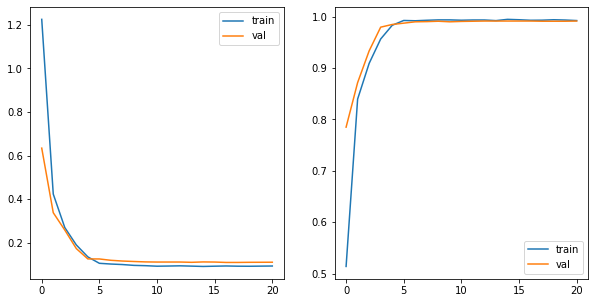

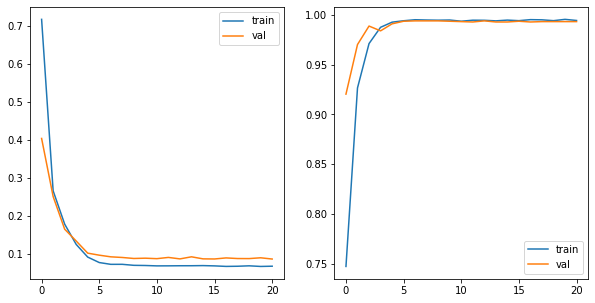

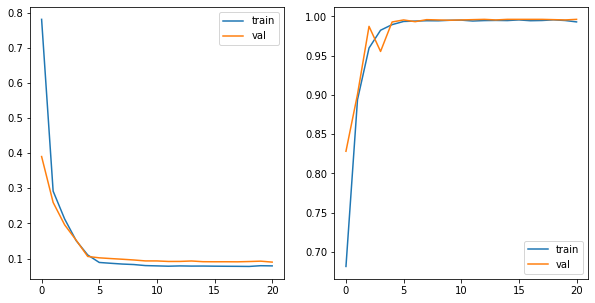

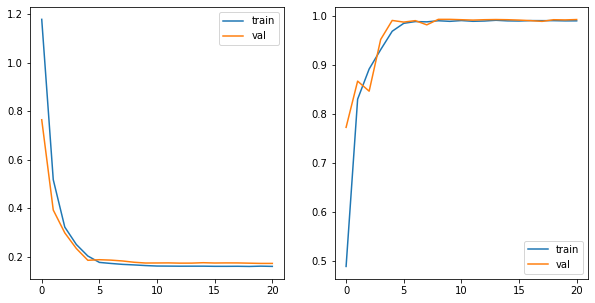

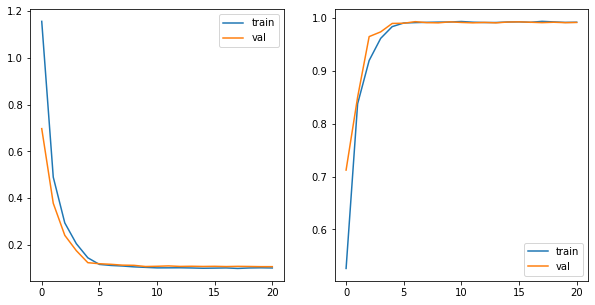

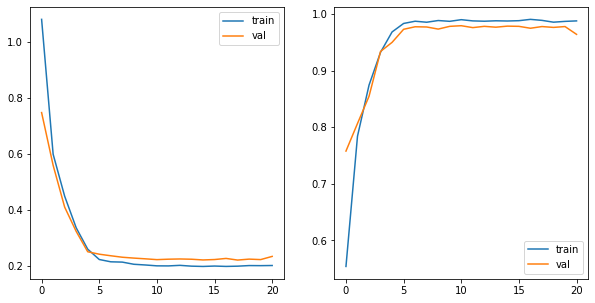

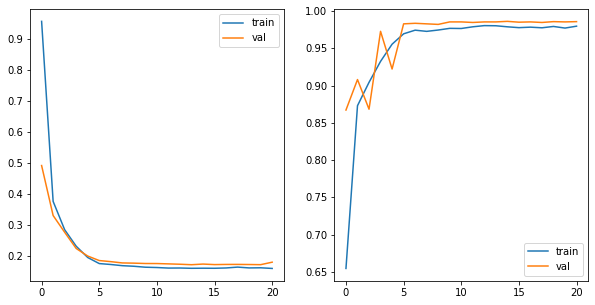

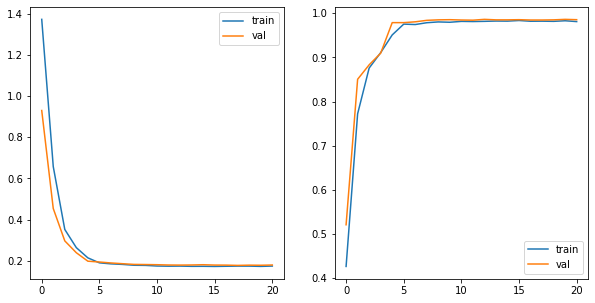

In [11]:
%%time
dict_pred = defaultdict(list)
file_names = []
for line in test_dataset.imgs:
    file_names.append(str(line).split('/')[-1].split('.')[0])

dict_pred['id'] = file_names

for i in trange(8):
    set_seed(SEED+i)
    
    net = SCNc6()
    net = net.to(device)
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adagrad(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
    train_model(net, loss, optimizer, scheduler, EPOCHS, train_nrj_loader, val_nrj_loader);
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(hystory_loss_train, label='train')
    ax1.plot(hystory_loss_val, label='val')
    ax1.legend()

    ax2.plot(hystory_acc_train, label='train')
    ax2.plot(hystory_acc_val, label='val')
    ax2.legend()
    
    net.eval()
    dict_pred[f'SCNc6-{i}'] = []
    with torch.no_grad():
        for _, (img, name) in enumerate(tqdm(test_loader)):
            img = img.to(device)
            outputs = net(img)
            _, predicted = torch.max(outputs.data, dim=1)
            predicted = list(map(int, predicted.cpu()))
            dict_pred[f'SCNc6-{i}'].extend(predicted)

    del net
    torch.cuda.empty_cache()

In [12]:
data_frame = pd.DataFrame.from_dict(dict_pred)
data_frame.head()

,id,SCNc6-0,SCNc6-1,SCNc6-2,SCNc6-3,SCNc6-4,SCNc6-5,SCNc6-6,SCNc6-7
0,private_test\\00013a94f1fae3e5a33f8b44c2842c85...,1,1,1,1,1,1,1,1
1,private_test\\0005564c011259402dcb6e3beb6e64d2...,4,4,4,4,4,4,4,4
2,private_test\\0007520c8d8efade8feaafbf74fc7d20...,2,2,2,4,2,2,2,2
3,private_test\\000804a189f630cd980ff1543c0ef99d...,0,0,0,0,0,0,0,0
4,private_test\\000eb12def5371089743dcfe401a8e39...,2,2,2,2,2,2,2,2


In [13]:
data_frame['SCNc6-0'] = data_frame['SCNc6-0'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['SCNc6-1'] = data_frame['SCNc6-1'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['SCNc6-2'] = data_frame['SCNc6-2'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['SCNc6-3'] = data_frame['SCNc6-3'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['SCNc6-4'] = data_frame['SCNc6-4'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['SCNc6-5'] = data_frame['SCNc6-5'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['SCNc6-6'] = data_frame['SCNc6-6'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['SCNc6-7'] = data_frame['SCNc6-7'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame.head()

,id,SCNc6-0,SCNc6-1,SCNc6-2,SCNc6-3,SCNc6-4,SCNc6-5,SCNc6-6,SCNc6-7
0,private_test\\00013a94f1fae3e5a33f8b44c2842c85...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,private_test\\0005564c011259402dcb6e3beb6e64d2...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
2,private_test\\0007520c8d8efade8feaafbf74fc7d20...,20.0,20.0,20.0,30.0,20.0,20.0,20.0,20.0
3,private_test\\000804a189f630cd980ff1543c0ef99d...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,private_test\\000eb12def5371089743dcfe401a8e39...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0


In [14]:
data_frame['id'] = data_frame['id'].apply(lambda x: x.split('\\\\')[1])
data_frame.head()

,id,SCNc6-0,SCNc6-1,SCNc6-2,SCNc6-3,SCNc6-4,SCNc6-5,SCNc6-6,SCNc6-7
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,0005564c011259402dcb6e3beb6e64d285124fa0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,20.0,20.0,20.0,30.0,20.0,20.0,20.0,20.0
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,000eb12def5371089743dcfe401a8e399f5883fc,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0


In [15]:
data_frame.to_csv('SCNc6.csv', index=False, header=True)